In [8]:
# Importando bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para regressão logística
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


df = pd.read_csv('/content/titanic_tratado_final (1).csv')
df.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinDeck,Fare_log
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,U,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,U,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,3.990834
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,U,2.202765


In [9]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Title        891 non-null    object 
 13  CabinDeck    891 non-null    object 
 14  Fare_log     891 non-null    float64
dtypes: float64(3), int64(5), object(7)
memory usage: 104.5+ KB


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


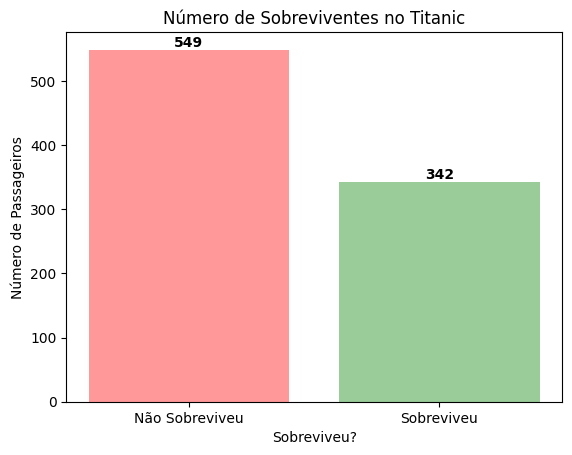

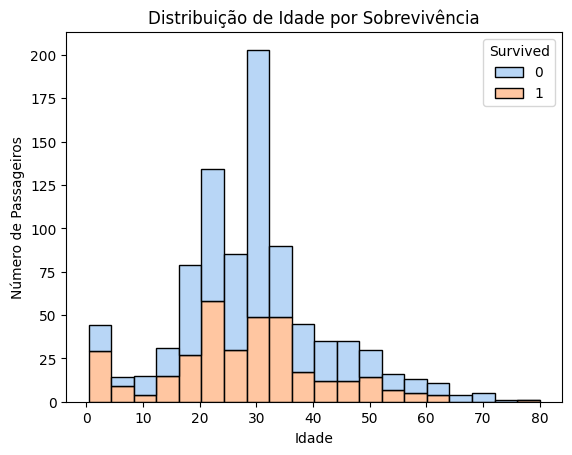

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de sobreviventes
plt.bar(['Não Sobreviveu', 'Sobreviveu'], df['Survived'].value_counts(), color=['#FF9999', '#99CC99'])
plt.title('Número de Sobreviventes no Titanic')
plt.ylabel('Número de Passageiros')
plt.xlabel('Sobreviveu?')
for i, v in enumerate(df['Survived'].value_counts()):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')
plt.show()

# Distribuição de idade por sobrevivência
sns.histplot(df, x='Age', hue='Survived', multiple='stack', bins=20, palette='pastel')
plt.title('Distribuição de Idade por Sobrevivência')
plt.xlabel('Idade')
plt.ylabel('Número de Passageiros')
plt.show()


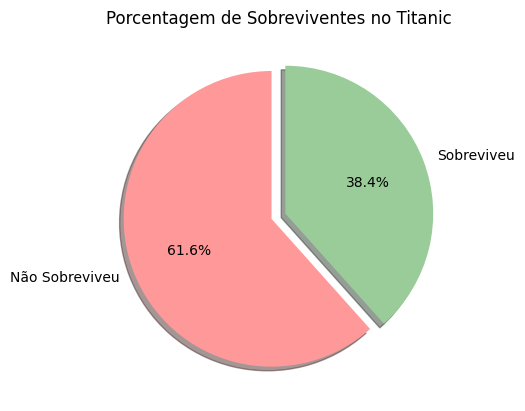

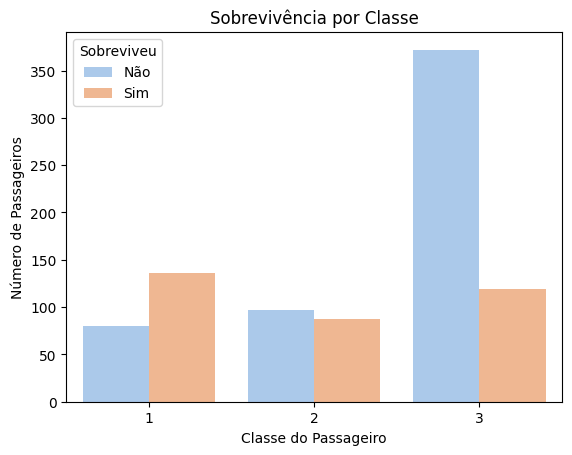

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pizza de sobreviventes
plt.pie(
    df['Survived'].value_counts(),
    labels=['Não Sobreviveu', 'Sobreviveu'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#FF9999', '#99CC99'],
    explode=(0.05, 0.05),
    shadow=True
)
plt.title('Porcentagem de Sobreviventes no Titanic')
plt.show()

# Sobrevivência por classe
sns.countplot(x='Pclass', hue='Survived', data=df, palette='pastel')
plt.title('Sobrevivência por Classe')
plt.xlabel('Classe do Passageiro')
plt.ylabel('Número de Passageiros')
plt.legend(title='Sobreviveu', labels=['Não', 'Sim'])
plt.show()


PARTE 1 — PRÉ-PROCESSAMENTO

In [12]:
# Extrair Title
title_map = {'Mr':'Mr','Mrs':'Mrs','Miss':'Miss','Master':'Master','Mlle':'Miss','Ms':'Miss','Mme':'Mrs'}
df['Title'] = df['Name'].str.extract(r',\s*([^.]*)\.')[0].map(title_map).fillna('Rare')

# Deck da cabine
df['CabinDeck'] = df['Cabin'].astype(str).str[0].replace('n','U')

# Idade por Title + fallback global
age_median = df.groupby('Title')['Age'].transform('median')
df['Age'] = df['Age'].fillna(age_median)
df['Age'] = df['Age'].fillna(df['Age'].median())

# Embarked e Fare
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Fare_log'] = np.log1p(df['Fare'])

# Features e target
features = ['Pclass','Sex','Age','SibSp','Parch','Fare_log','Embarked','Title','CabinDeck']
X = pd.get_dummies(df[features], drop_first=True)
y = df['Survived']

# Escalonamento
X[['Age','Fare_log']] = StandardScaler().fit_transform(X[['Age','Fare_log']])

print("Pré-processamento concluído. Shape:", X.shape)

Pré-processamento concluído. Shape: (891, 20)


PARTE 2 — TREINO DO MODELO

In [14]:
# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Treinar Regressão Logística
model = LogisticRegression(max_iter=5000, solver='liblinear')
model.fit(X_train, y_train)

print("Treinamento concluído.")


Treinamento concluído.


PARTE 3 — AVALIAÇÃO

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Previsões
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

# Métricas
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:\n", cm)


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

ROC AUC: 0.861133069828722
Matriz de Confusão:
 [[98 12]
 [18 51]]


PARTE 4 — GRÁFICOS

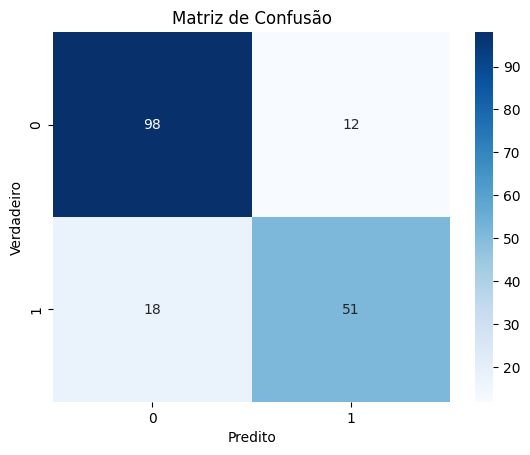

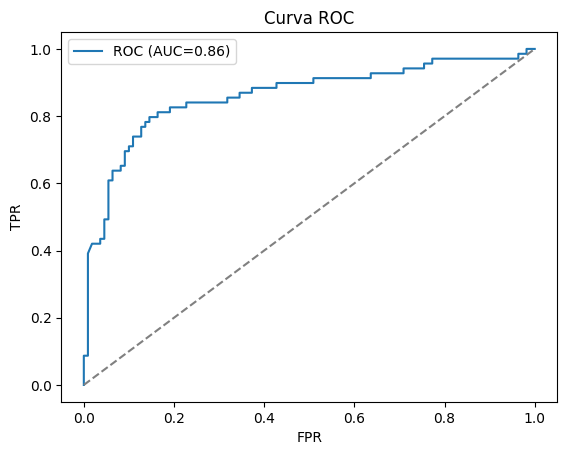

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz de confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc_score(y_test,y_proba):.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend()
plt.show()


PARTE 5 — IMPORTÂNCIA DAS VARIÁVEIS

Top 15 features por impacto absoluto:
         Feature      Coef
9      Title_Mr -2.018929
10    Title_Mrs  1.519782
15  CabinDeck_E  1.078901
14  CabinDeck_D  0.988962
8    Title_Miss  0.636107
17  CabinDeck_G -0.582233
4      Fare_log  0.533859
2         SibSp -0.523211
19  CabinDeck_U -0.522306
11   Title_Rare -0.516011
1           Age -0.510002
16  CabinDeck_F  0.497471
3         Parch -0.366150
0        Pclass -0.364703
6    Embarked_Q  0.280117


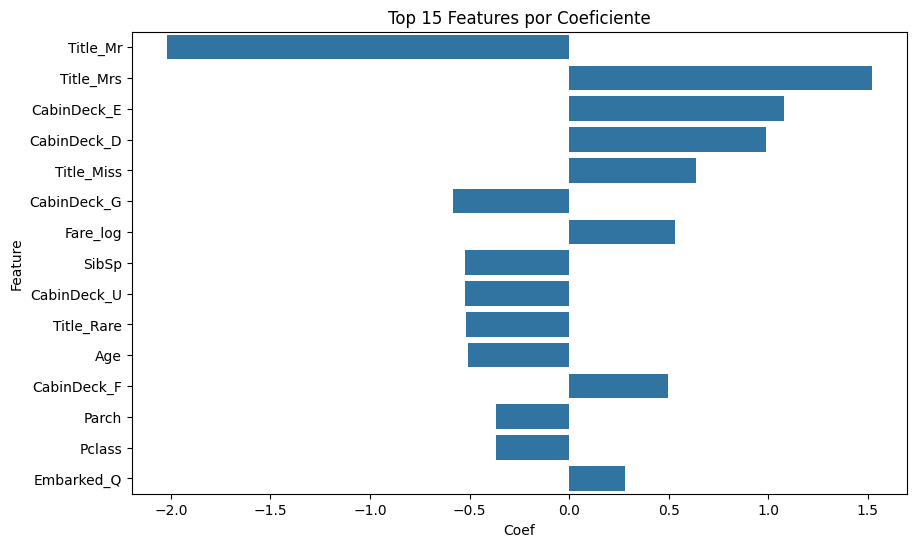

In [18]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coef': model.coef_.flatten()
}).sort_values(by='Coef', key=lambda x: x.abs(), ascending=False)

print("Top 15 features por impacto absoluto:\n", coef_df.head(15))

plt.figure(figsize=(10,6))
sns.barplot(x='Coef', y='Feature', data=coef_df.head(15))
plt.title('Top 15 Features por Coeficiente')
plt.show()


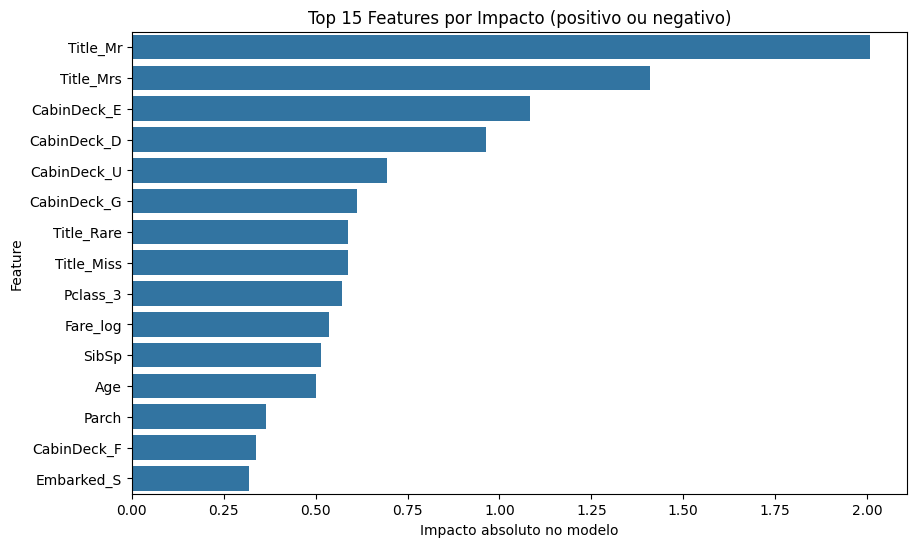

In [ ]:
coef_df['abs_coef'] = coef_df['Coef'].abs()
top_coef = coef_df.sort_values(by='abs_coef', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='abs_coef', y='Feature', data=top_coef )
plt.xlabel('Impacto absoluto no modelo')
plt.title('Top 15 Features por Impacto (positivo ou negativo)')
plt.show()
